<a href="https://colab.research.google.com/github/lilyzhizhou/ML-Final-Project/blob/main/Logistic_Regression_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import plotly.express as px
import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import Pre-Diabetes Data
datapd = pd.read_csv('/content/drive/MyDrive/Machine Learning /Datathon #3/datapd.csv')

# Drop Patient_ID
datapd.drop('Patient_ID', axis = 1, inplace = True)
datapd.drop('Unnamed: 0', axis = 1, inplace = True)

print(datapd.shape)
datapd.head()

(6414, 11)


,predm,Age_at_Exam,BMI,Total_Cholesterol,Depression,HTN,OA,COPD,corstrd_bin,htnmed_bin,Sex
0,1,63,30.9,NaN,0,1,0,1,0,1,1
1,1,66,23.6,3.54,1,1,1,0,0,1,1
2,0,68,34.3,5.55,1,1,1,0,0,1,0
3,1,73,28.5,3.78,1,1,0,1,1,1,0
4,0,53,33.4,5.38,0,1,1,0,1,1,0


In [ ]:
# Look for NA values
print(datapd.isnull().sum())

predm                  0
Age_at_Exam            0
BMI                    0
Total_Cholesterol    152
Depression             0
HTN                    0
OA                     0
COPD                   0
corstrd_bin            0
htnmed_bin             0
Sex                    0
dtype: int64


Determining Optimal Model parameters

---



In [4]:
# 1. Split the data into features and target variable
X = datapd.drop('predm', axis=1)
y = datapd['predm']

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Split the training set into a smaller training set and a validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# 4. Imputation of missing values
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_valid = imputer.fit_transform(X_valid)
X_test = imputer.fit_transform(X_test)
# Selected median bc it works well with skewed continuous data and is less sensitive to outliers and overfitting

# 5. Normalization of the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)

# 6. Initialize a Logistic Regression model
model = LogisticRegression()

# Define a KFold cross-validation
cv = KFold(10)

# Initialize Recursive Feature Elimination with Cross-Validation (RFECV)
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv,
    scoring='roc_auc',  # Specify the scoring metric (ROC AUC in this case)
    min_features_to_select=1,
)
rfecv.fit(X_train, y_train)

# Print the optimal number of selected features
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 7


- the optimal number of features to include is 7
- we currently have 10 predictors

In [5]:
# which columns used and which wasn't
rfecv.support_

array([ True,  True,  True, False,  True, False,  True, False,  True,
        True])

In [6]:
# features ranking low is better
rfecv.ranking_

array([1, 1, 1, 2, 1, 4, 1, 3, 1, 1])

Using Gridsearch to determine hyperparameters for logistic regression

---



In [7]:
import numpy as np
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# 1. Select only the features that were chosen by RFECV
X_train = X_train[:, rfecv.support_]
X_valid = X_valid[:, rfecv.support_]
X_test = X_test[:, rfecv.support_]

# 3. Use pipeline for gridsearchCV
std_slc = StandardScaler()
pca = decomposition.PCA()
logistic_Reg = linear_model.LogisticRegression()

pipe = Pipeline(steps=[('std_slc', std_slc),
 ('pca', pca),
  ('logistic_Reg', logistic_Reg)])

C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2','none']

parameters = dict(logistic_Reg__C=C,
                  logistic_Reg__penalty=penalty)

# 4. Run gridsearch
clf_GS = GridSearchCV(pipe, parameters, cv = cv)

clf_GS.fit(X_train, y_train)

# Extracting the results of the Grid Search into a DataFrame for analysis.
results = pd.DataFrame(clf_GS.cv_results_)

# Filtering to get the rows with the best performing hyperparameters.
print(results[results['rank_test_score'] == 1])

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
28       0.015926      0.002232         0.001204        0.000472   

   param_logistic_Reg__C param_logistic_Reg__penalty  \
28              0.002947                          l2   

                                               params  split0_test_score  \
28  {'logistic_Reg__C': 0.0029470517025518097, 'lo...           0.625974   

    split1_test_score  split2_test_score  split3_test_score  \
28           0.607792           0.636364           0.641558   

    split4_test_score  split5_test_score  split6_test_score  \
28           0.607792           0.638961           0.649351   

    split7_test_score  split8_test_score  split9_test_score  mean_test_score  \
28           0.649351           0.658854           0.619792         0.633579   

    std_test_score  rank_test_score  
28        0.016777                1  


In [8]:
print('Best Penalty:', clf_GS.best_estimator_.get_params()['logistic_Reg__penalty'])
print('Best C:', clf_GS.best_estimator_.get_params()['logistic_Reg__C'])

Best Penalty: l2
Best C: 0.0029470517025518097


- will use these parameters for final model

Final Model Building

---



In [9]:
# 1. Training logistic regression model
log_reg = LogisticRegression(penalty= 'l2', C=0.0029470517025518097, solver='lbfgs')
log_reg.fit(X_train, y_train)

# L2 regularization used as it will spread coefficient values more evenly across all predictors
# lbfgs used as for it's robustness

LogisticRegression(C=0.0029470517025518097)

In [10]:
# Define a function to compute various scores for model evaluation
def get_scores(Y_pred, Y):
    # Calculate confusion matrix, classification report, ROC AUC, accuracy, recall, precision, fi
    conf_matrix = confusion_matrix(Y_pred, Y)
    auc = roc_auc_score(Y_pred, Y)
    acc = accuracy_score(Y_pred, Y)
    precision = precision_score(Y_pred, Y)
    recall = recall_score(Y_pred, Y)
    f1 = f1_score(Y_pred, Y)
    class_report = classification_report(Y_pred, Y)

    # Return the computed scores
    return conf_matrix, auc, acc, precision, recall, f1, class_report

# Define a function to print the computed scores
def print_scores(conf_matrix, auc, acc, precision, recall, f1, class_report):
    print("Confusion Matrix:")
    print(conf_matrix)
    print('AUC : ', auc)
    print('Accuracy : ', acc)
    print("\nPrecision:")
    print(precision)
    print("\nRecall:")
    print(recall)
    print("\nf1-score:")
    print(f1)
    print("\nClassification Report:")
    print(class_report)

In [11]:
# 3.  Use the model to make predictions on the vaidation and training data
y_pred_valid = log_reg.predict(X_valid)
y_pred_train = log_reg.predict(X_train)

# 4.  Evaluate the model
conf_matrix_valid, auc_valid, acc_valid, precision_valid, recall_valid, f1_valid, class_report_valid = get_scores(y_pred_valid, y_valid)
conf_matrix_train, auc_train, acc_train, precision_train, recall_train, f1_train, class_report_train = get_scores(y_pred_train, y_train)

# Print scores and evaluation metrics for the training set
print('======== Train Set ==========')
print_scores(conf_matrix_train, auc_train, acc_train, precision_train, recall_train, f1_train, class_report_train)

# Print scores and evaluation metrics for the validation set
print('======== Validation Set ==========')

print_scores(conf_matrix_valid, auc_valid, acc_valid, precision_valid, recall_valid, f1_valid, class_report_valid)

======== Train Set ==========
Confusion Matrix:
[[1812  945]
 [ 447  644]]
AUC :  0.6237601346061205
Accuracy :  0.6382536382536382

Precision:
0.4052863436123348

Recall:
0.5902841429880843

f1-score:
0.4805970149253731

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.66      0.72      2757
           1       0.41      0.59      0.48      1091

    accuracy                           0.64      3848
   macro avg       0.60      0.62      0.60      3848
weighted avg       0.69      0.64      0.65      3848

======== Validation Set ==========
Confusion Matrix:
[[614 288]
 [165 216]]
AUC :  0.6238193341131693
Accuracy :  0.646921278254092

Precision:
0.42857142857142855

Recall:
0.5669291338582677

f1-score:
0.488135593220339

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.68      0.73       902
           1       0.43      0.57      0.49       381

    accuracy       

- since the goal is to identify pre-diabetics, we want the least false negatives
- prioritize recall
- recall for the the validation model is 0.57 which is low

Test set

---



In [12]:
# Use the model to make predictions on the vaidation and test data
y_pred_test = log_reg.predict(X_test)

# Evaluate the model
conf_matrix_test, auc_test, acc_test, precision_test, recall_test, f1_test, class_report_test = get_scores(y_pred_test, y_test)

# Print scores and evaluation metrics for the test set
print('======== Test Set ==========')
print_scores(conf_matrix_test, auc_test, acc_test, precision_test, recall_test, f1_test, class_report_test)

======== Test Set ==========
Confusion Matrix:
[[596 308]
 [164 215]]
AUC :  0.6132871786489831
Accuracy :  0.6321122369446609

Precision:
0.4110898661567878

Recall:
0.5672823218997362

f1-score:
0.47671840354767187

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.66      0.72       904
           1       0.41      0.57      0.48       379

    accuracy                           0.63      1283
   macro avg       0.60      0.61      0.60      1283
weighted avg       0.67      0.63      0.65      1283



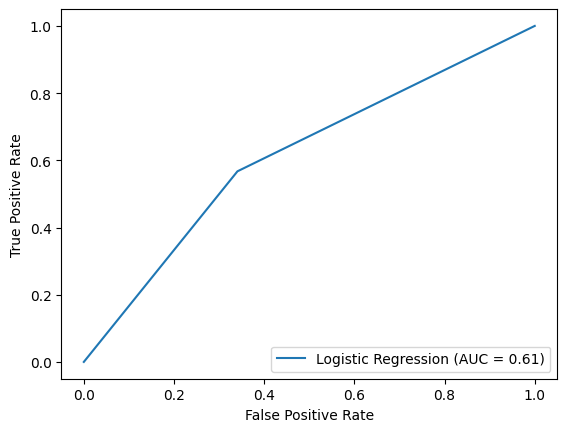

In [13]:
# Plot the ROC curve for the test set
fpr, tpr, thresholds = roc_curve(y_pred_test, y_test)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
display.plot()

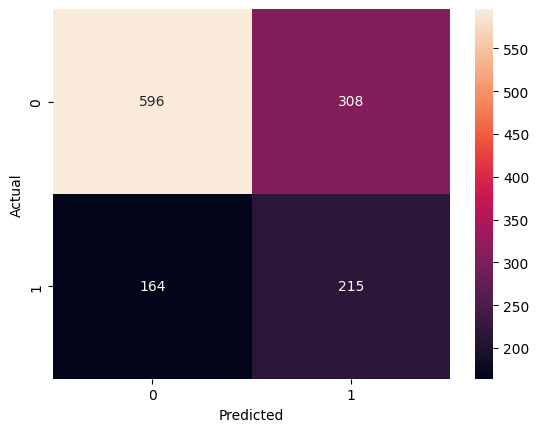

In [14]:
# Visualizing confusion matrix Test
sns.heatmap(conf_matrix_test, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [15]:
# Imputation of missing values
datapd['Total_Cholesterol'].fillna(datapd['Total_Cholesterol'].median(), inplace = True)

# Separate features and target variable
X = datapd.drop('predm', axis=1)
y = datapd['predm']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Create and fit logistic regression model
log_reg = sm.Logit(y, X).fit()

# Get summary report
summary = log_reg.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.624183
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  predm   No. Observations:                 6414
Model:                          Logit   Df Residuals:                     6403
Method:                           MLE   Df Model:                           10
Date:                Sat, 02 Dec 2023   Pseudo R-squ.:                 0.07675
Time:                        17:34:38   Log-Likelihood:                -4003.5
converged:                       True   LL-Null:                       -4336.3
Covariance Type:            nonrobust   LLR p-value:                1.514e-136
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -3.4477      0.261    -13.226      0.000      -3.959      -2.937
Age_at_E

variables that were significant:
- Age
- BMI
- Total_Cholesterol
- htnmed_bin
